In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
data.shape
labels = data[:,0]
data = data[:,1:]


In [30]:
# convert data to tensor
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long() # long = int64

_train_data, _test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

In [32]:
def getData(challenge):

    match challenge:
        case 0: # training data in range [0, 1]; test data in range [0, 1]
            train_data = _train_data/torch.max(_train_data)
            test_data = _test_data/torch.max(_test_data)
        case 1: # training data in range [0, 1]; test data in range [0, 255]
            train_data = _train_data/torch.max(_train_data)
            test_data = _test_data
        case 2: # training data in range [0, 255]; test data in range [0, 1]
            train_data = _train_data
            test_data = _test_data/torch.max(_test_data)
            
    print('Training data range %g to %g' %(torch.min(train_data), torch.max(train_data)))
    print('Testing data range %g to %g' %(torch.min(test_data), torch.max(test_data)))

    

    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)


    batchSize = 32
    train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_data.__len__())

    return train_loader, test_loader


In [28]:
getData(2)

Training data range 0 to 255
Testing data range 0 to 1


In [33]:
%whos

Variable            Type        Data/Info
-----------------------------------------
DataLoader          type        <class 'torch.utils.data.dataloader.DataLoader'>
F                   module      <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type        <class 'torch.utils.data.dataset.TensorDataset'>
data                ndarray     20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor      tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
getData             function    <function getData at 0x28e9485e0>
labels              ndarray     20000: 20000 elems, type `float64`, 160000 bytes (156.25 kb)
labelsT             Tensor      tensor([6, 5, 7,  ..., 2, 9, 5])
matplotlib_inline   module      <module 'matplotlib_inlin<...>tlib_inline/__init__.py'>
nn                  module      <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np                  module      <module 'numpy' from '/Us<...>kages/n

In [53]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = torch.log_softmax(self.output(x), axis=1)
        # log_softmax() because of NLLLoss instead of CrossEntropyLoss

        return x

In [54]:
def getModel():
    ANN = Model()
    lossFunction = nn.NLLLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [36]:
def trainModel(ANN, lossFunction, optimizer, train_loader, test_loader):
    epochs = 60

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [55]:
train_loader, test_loader = getData(0)
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer, train_loader, test_loader)

Training data range 0 to 1
Testing data range 0 to 1


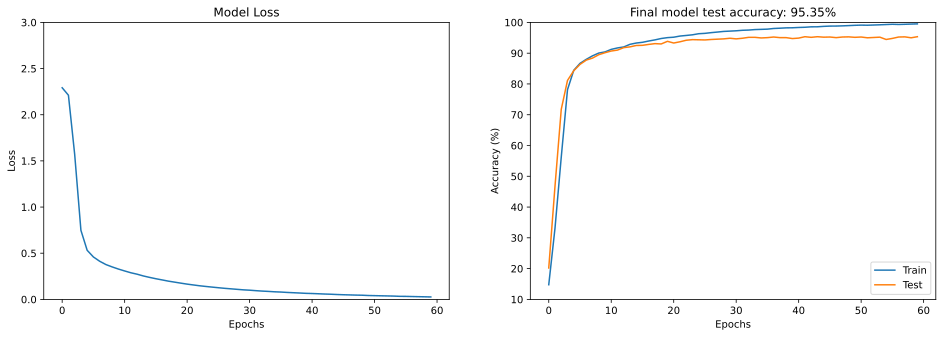

In [56]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [57]:
train_loader, test_loader = getData(1)
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer, train_loader, test_loader)

Training data range 0 to 1
Testing data range 0 to 255


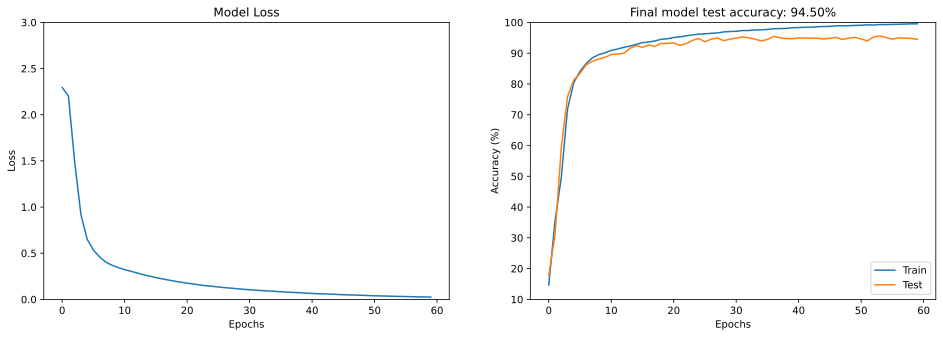

In [58]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [59]:
train_loader, test_loader = getData(2)
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer, train_loader, test_loader)

Training data range 0 to 255
Testing data range 0 to 1


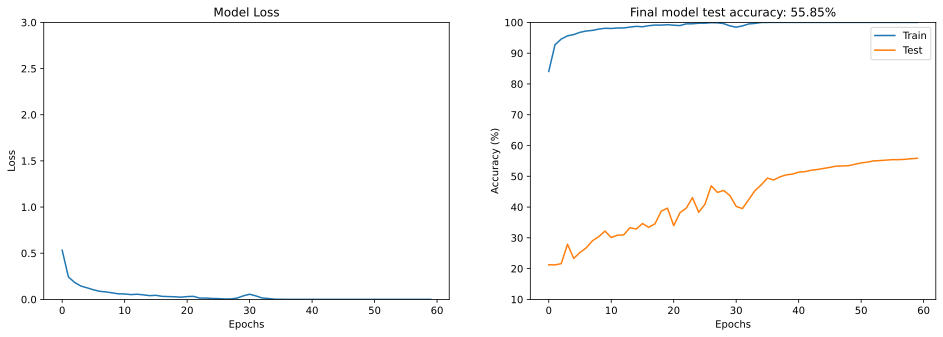

In [60]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

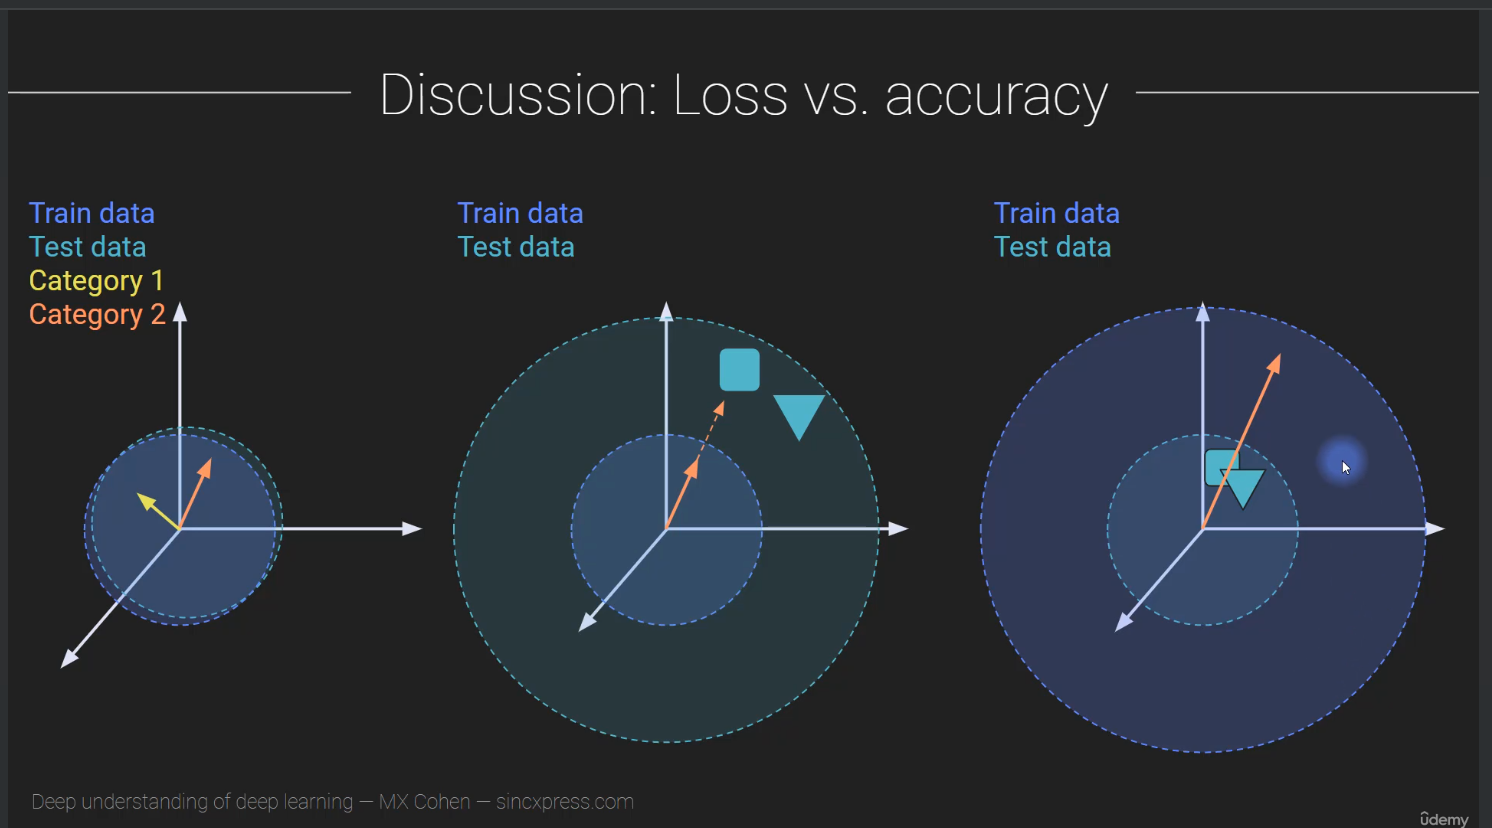